In [ ]:
!pip install -U datasets evaluate

In [41]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import evaluate
import math
import matplotlib.pyplot as plt
import torch
from torch import nn
import wandb
from transformer import Transformer
import pandas as pd
import csv

In [43]:
FILE_PATH = "../input/dataset-for-translate"

In [45]:
data_files = {'train': f'{FILE_PATH}/multi30k_train.csv', 'test': F'{FILE_PATH}/multi30k_test.csv'}
dataset = load_dataset('csv', data_files=data_files)
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

In [46]:
len(dataset["train"]) // 500

58

In [47]:
train_loader = DataLoader(dataset['train'], shuffle=True, batch_size=64)
test_loader = DataLoader(dataset['test'], shuffle=False, batch_size=64)

In [48]:
SRC_NAME = 'de'
TRG_NAME = 'en'
MAX_LENGTH = 64

In [49]:
tokenizers = {
    'en': AutoTokenizer.from_pretrained('bert-base-uncased'),
    'de': AutoTokenizer.from_pretrained('dbmdz/bert-base-german-uncased')
}

In [50]:
# transformer = Transformer(
#     encoder_vocab_size=tokenizers["en"].vocab_size, decoder_vocab_size=tokenizers["de"].vocab_size, hidden_size=64 * 6, n_head=6,
#     intermediate_size=256, encoder_max_len=512, decoder_max_len=512, n_layers=2, drop_prob=0.3
# )

In [51]:
# src_input_ids = torch.randint(0, 4, size=(10, 4))
# src_attention_mask = torch.randint(0, 2, size=(10, 4))
# 
# trg_input_ids = torch.randint(0, 8, size=(10, 3))
# trg_attention_mask = torch.randint(0, 2, size=(10, 3))
# 
# output_shape = transformer(src_input_ids, trg_input_ids, src_attention_mask, trg_attention_mask).shape
# print(output_shape)
# assert output_shape == (10, 3, 8)
# 
# print('Вроде все работает.')

In [53]:
bleu_score = evaluate.load('bleu')

In [54]:
class ExponentialMovingAverage:
    def __init__(self, parameters, decay=0.999):
        super().__init__()

        self.decay = decay
        self.parameters = [p.clone().detach() for p in parameters if p.requires_grad]

    @torch.no_grad()
    def update(self, parameters):
        parameters = [p for p in parameters if p.requires_grad]
        for s_param, param in zip(self.parameters, parameters):
            s_param.sub_((1.0 - self.decay) * (s_param - param))

    def state_dict(self) -> dict:
        return {'parameters': self.parameters}
    
    @torch.no_grad()
    def copy_to(self, parameters):
        parameters = [p for p in parameters if p.requires_grad]
        for s_param, param in zip(self.parameters, parameters):
            param.data.copy_(s_param.data)

In [55]:
class WarmupCosineScheduler:
    def __init__(self, optimizer, warmup_steps=2000, max_training_steps=40000, min_lr=1e-6):        
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.max_training_steps = max_training_steps
        self.min_lr = min_lr
        
        self.current_step = 0
        self.max_lr = optimizer.param_groups[0]['lr']

    def step(self):
        self.current_step += 1
        
        if self.current_step <= self.warmup_steps:
            lr = self.min_lr * (1 - self.current_step / self.warmup_steps) + self.max_lr * (self.current_step / self.warmup_steps)
        else:
            lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + math.cos(math.pi * (self.current_step - self.warmup_steps) / (self.max_training_steps - self.warmup_steps)))
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']

Text(0, 0.5, 'Learning rate')

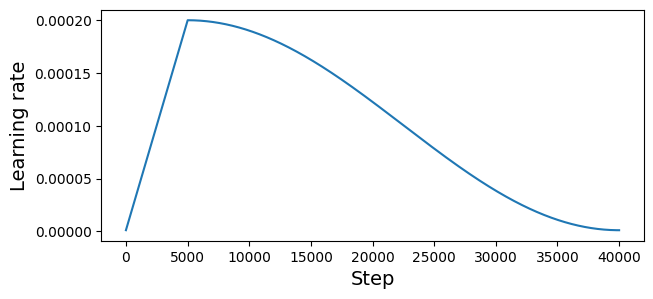

In [56]:
dummy_model = nn.Linear(1, 1)
optimizer = torch.optim.Adam(dummy_model.parameters(), lr=2e-4)
scheduler = WarmupCosineScheduler(optimizer, warmup_steps=5000, max_training_steps=40000, min_lr=1e-6)

lrs = []
for i in range(40000):
    optimizer.step()
    scheduler.step()
    lrs.append(scheduler.get_lr())

plt.figure(figsize=(7, 3))
plt.plot(lrs)
plt.xlabel('Step', size=14)
plt.ylabel('Learning rate', size=14)

In [57]:
a = next(iter(test_loader))["en"][0]
b = tokenizers['en'](a, padding="max_length", max_length=32, truncation=True)
# tokenizers["en"].decode(b["input_ids"])
b

{'input_ids': [101, 1037, 2158, 1999, 2019, 4589, 6045, 4626, 2012, 2242, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [58]:
a = torch.rand((10, 5, 8))
a[: , :-1, :].shape

torch.Size([10, 4, 8])

In [59]:
tokenizers["en"].pad_token_id

0

In [61]:
tokenizers["de"].convert_tokens_to_ids("[CLS]")

102

In [62]:
tokenizers["en"].convert_ids_to_tokens(0)

'[PAD]'

In [63]:
torch.argmax(torch.tensor([torch.nan, torch.nan, torch.nan]))

tensor(0)

In [64]:
def post_processing_text(texts):
    clean_texts = []
    for text in texts:
        full_stop_pos = text.find(".")
        if full_stop_pos  != -1:
            text = text[:full_stop_pos+1]

        clean_texts.append(text)
        
    return clean_texts


def generate(model, input_data, max_len, tokenizer, device):
    model.eval()
    model.to(device)
    
    src_input_ids = input_data['input_ids'].to(device)
    
    batch_size = src_input_ids.size(0)
    generated_ids = torch.full((batch_size, 1), tokenizer.convert_tokens_to_ids("[CLS]"), device=device)
    
    with torch.no_grad():
        for _ in range(max_len):
            logits = model(src_input_ids=src_input_ids, trg_input_ids=generated_ids)
            next_token_logits = logits[:, -1, :]
            next_token_ids = next_token_logits.argmax(dim=-1, keepdim=True)

            generated_ids = torch.cat([generated_ids, next_token_ids], dim=1)
    
    return generated_ids

In [65]:
tokenizers[SRC_NAME](["dvbfbfrvwerverver", "dfafawf"], padding=True, return_tensors="pt")

{'input_ids': tensor([[  102, 20513, 14085, 14085, 19515,   357,   268,   268,   103],
        [  102,   107,  1201,  1201, 28240,   103,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0]])}

In [66]:
def train(model: nn.Module, optimizer, scheduler, ema_model, criterion, loader, epoch, device: str = "cpu"):
    model.train()
    model.to(device)
    
    for i, X in enumerate(loader):
        X_en = tokenizers[SRC_NAME](X[SRC_NAME], padding="max_length", max_length=MAX_LENGTH, truncation=True, return_tensors="pt").to(device)
        X_de = tokenizers[TRG_NAME](X[TRG_NAME], padding="max_length", max_length=MAX_LENGTH, truncation=True, return_tensors="pt").to(device).to(device)
        
        preds = model(X_en["input_ids"],  X_de["input_ids"])
        
        preds_for_loss = preds[:, :-1]
        trg_for_loss = X_de["input_ids"][:, 1:]
        
        loss = criterion(preds_for_loss.permute(0, 2, 1), trg_for_loss)
        wandb.log({"Train loss": loss.detach().item()})

        if i % 5 == 0:
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            if ema_model is not None:
                ema_model.update(model.parameters())
            optimizer.zero_grad()
        
@torch.no_grad()
def evaluate(model: nn.Module, criterion, loader, device: str = "cpu"):
    model.eval()
    model.to(device)
    
    text_predictions = []
    text_references = []
    for i, X in enumerate(loader):
        X_en = tokenizers[SRC_NAME](X[SRC_NAME], padding="max_length", max_length=64, truncation=True, return_tensors="pt").to(device)
        X_de = tokenizers[TRG_NAME](X[TRG_NAME], padding="max_length", max_length=64, truncation=True, return_tensors="pt").to(device)
        
        preds = model(X_en["input_ids"], X_de["input_ids"])
        preds_for_loss = preds[:, :-1]
        trg_for_loss = X_de["input_ids"][:, 1:]
        loss = criterion(preds_for_loss.permute(0, 2, 1), trg_for_loss)
        wandb.log({"Train loss": loss.detach().item()})
        
        gen_ids = generate(model=model, input_data=X_en, max_len=64, tokenizer=tokenizers[TRG_NAME], device=device)
        text_predictions.extend(post_processing_text(tokenizers[TRG_NAME].batch_decode(gen_ids, skip_special_tokens=True)))
        text_references.extend(tokenizers[TRG_NAME].batch_decode(X_de['input_ids'], skip_special_tokens=True))
        
    bleu_results = bleu_score.compute(predictions=text_predictions, references=text_references)
    wandb.log({"BLEU": bleu_results["bleu"]})

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [69]:
model = Transformer(encoder_vocab_size=tokenizers[SRC_NAME].vocab_size, decoder_vocab_size=tokenizers[TRG_NAME].vocab_size, hidden_size=21 * 6, n_head=6,
    intermediate_size=21 * 3, encoder_max_len=512, decoder_max_len=512, n_layers=6, drop_prob=0.3).to(device)

N_EPOCH = 100

ema_model = ExponentialMovingAverage(model.parameters(), decay=0.999)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

scheduler = WarmupCosineScheduler(optimizer, warmup_steps=250, max_training_steps=N_EPOCH * len(dataset["train"]), min_lr=1e-6)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=tokenizers[TRG_NAME].pad_token_id)

print('Model parameters:', sum(torch.numel(p) for p in model.parameters()))

Model parameters: 13122930


In [70]:
wandb.login(key="d7f5d727d48aa07df7e9d741e9bbbc88ed342500")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [71]:
with wandb.init(project="Transformer for translate"):
    for e in range(N_EPOCH):
        train(model, optimizer, scheduler, ema_model, loss_fn, train_loader, e, device)
        evaluate(model, loss_fn, test_loader, device)

Traceback (most recent call last):
  File "<ipython-input-71-638222fbb62c>", line 3, in <cell line: 1>
    train(model, optimizer, scheduler, ema_model, loss_fn, train_loader, e, device)
  File "<ipython-input-66-ac97ded620a1>", line 29, in train
    batch_true_preds = (torch.argmax(preds_for_loss.detach().cpu(), dim=-1) == trg_for_loss.cpu()).float()
KeyboardInterrupt


BLEU,▁▂▃▄▅▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇██▇█████████████████
Train loss,████▆▅▅▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▅▁▂▁▁▁▁▁▁
BLEU,0.34591
Train loss,0.96045


KeyboardInterrupt: 

In [73]:
@torch.no_grad()
def measure_bleu_and_save(model, input_file=f'{FILE_PATH}/multi30k_grader.csv', output_file=f'solution.tsv'):
    model.eval()
    text_predictions = []

    data = pd.read_csv(input_file)

    for index, row in data.iterrows():
        input_text = row['de']
        input_ids = tokenizers[SRC_NAME](input_text, return_tensors='pt', padding="max_length", truncation=True, max_length=MAX_LENGTH).to(device)

        gen_ids = generate(model, input_ids, MAX_LENGTH, tokenizers['de'], device=device)
        translation = post_processing_text(tokenizers[TRG_NAME].batch_decode(gen_ids, skip_special_tokens=True))
        text_predictions.append(translation[0])
    with open(output_file, 'w', newline='', encoding='utf-8') as tsvfile:
        writer = csv.writer(tsvfile, delimiter='\t')
        writer.writerow(['prediction'])
        for prediction in text_predictions:
            writer.writerow([prediction])

    return text_predictions

predictions = measure_bleu_and_save(model)

In [74]:
torch.save(model, "MyTFTrans-1.0.pt")